# Prepare environment
Load libraries, etc.

In [ ]:
%pip install -q transformers librosa datasets==2.14.6 evaluate jiwer gradio bitsandbytes==0.37 accelerate geomloss gradio torchaudio
%pip install -q git+https://github.com/huggingface/peft.git@main

In [ ]:
from huggingface_hub import notebook_login

notebook_login() #huggingface-cli login workaround

In [2]:
from datasets import load_dataset, DatasetDict
from transformers import (WhisperFeatureExtractor, 
                          WhisperTokenizer, 
                          WhisperProcessor,
                          WhisperModel,
                          WhisperForConditionalGeneration, 
                          Seq2SeqTrainingArguments, 
                          Seq2SeqTrainer, 
                          TrainerCallback, 
                          TrainingArguments, 
                          TrainerState, 
                          TrainerControl)
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from geomloss import SamplesLoss
from peft import (prepare_model_for_int8_training,
                  LoraConfig, 
                  PeftModel, 
                  LoraModel, 
                  LoraConfig, 
                  TaskType,
                  get_peft_model)
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
import re


# Prepare data

In [3]:
sd_qa = DatasetDict()

sd_qa["dev"] = load_dataset("WillHeld/SD-QA", split="dev", token=True)
sd_qa["test"] = load_dataset("WillHeld/SD-QA", split="test", token=True)
saved_data = sd_qa
print(sd_qa)
print(sd_qa['dev'])

/Applications/miniconda3/envs/cs224n-project-env/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


DatasetDict({
    dev: Dataset({
        features: ['id', 'aus', 'gbr', 'ind_n', 'ind_s', 'irl', 'kenya', 'nga', 'nzl', 'phl', 'usa', 'zaf', 'answers', 'question'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'aus', 'gbr', 'ind_n', 'ind_s', 'irl', 'kenya', 'nga', 'nzl', 'phl', 'usa', 'zaf', 'answers', 'question'],
        num_rows: 1031
    })
})
Dataset({
    features: ['id', 'aus', 'gbr', 'ind_n', 'ind_s', 'irl', 'kenya', 'nga', 'nzl', 'phl', 'usa', 'zaf', 'answers', 'question'],
    num_rows: 1000
})


In [4]:
# select only target and source dialect
sd_qa = saved_data
target_dialect = 'usa'
source_dialect = 'ind_n'
sd_qa = sd_qa.select_columns(['id', 
                              source_dialect, 
                              target_dialect, 
                              # 'question'
                              ])
print(sd_qa['dev'][0])

{'id': '-1008642825401516622', 'ind_n': {'path': None, 'array': array([ 0.00000000e+00, -3.05175781e-05, -3.05175781e-05, ...,
        3.96728516e-04,  2.13623047e-04,  6.10351562e-05]), 'sampling_rate': 16000}, 'usa': {'path': None, 'array': array([0.        , 0.        , 0.        , ..., 0.00201416, 0.00259399,
       0.00262451]), 'sampling_rate': 16000}}


In [5]:
# load whisper feature extractor, tokenizer, processor
model_path = "openai/whisper-base"
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_path)
task = "transcribe"
tokenizer = WhisperTokenizer.from_pretrained(model_path, task=task)
processor = WhisperProcessor.from_pretrained(model_path, task=task)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
import torch
p = torch.load("../base-embeddings/-1008642825401516622.pt")
q = torch.load("../base-embeddings/-1008642825401516622.pt")
print(torch.cat([p,q]).shape)

torch.Size([2, 1500, 512])


In [6]:
# define prepare dataset function to extract audio features
def prepare_source_data(data):
    # compute log-Mel input features from audio arrays
    data["source_input_features"] = feature_extractor(data[source_dialect]["array"], sampling_rate=data[source_dialect]["sampling_rate"]).input_features[0]
    data["target_input_features"] = feature_extractor(data[target_dialect]["array"], sampling_rate=data[target_dialect]["sampling_rate"]).input_features[0]
    return data


In [ ]:
sample['target_embeddings'][0]

In [7]:
# generate fixed embeddings
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")

def prepare_target_embeddings(data):
    # compute log-Mel input features from target audio array
    batch_size = 128
    target_embeddings = []
    decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id
    for i in range(0, len(data["target_input_features"]), batch_size):
        input_features = torch.tensor(data["target_input_features"][i: i + batch_size])
        with torch.no_grad():
            outputs = model(input_features, decoder_input_ids=decoder_input_ids, output_hidden_states=True)
        last_hidden_state = outputs.encoder_hidden_states[-1]
        target_embeddings.extend([embedding for embedding in last_hidden_state])
    data["target_embeddings"] = target_embeddings
    return data

In [14]:
sample = sd_qa['dev'].select([10,11,12,13,14,15])
sample = sample.map(
        prepare_source_data, 
        num_proc=2, 
        desc="Extract features for source dialect"
    )
# .map(
#         prepare_target_embeddings,
#         batched=True,
#         desc="Original hidden embeddings for target dialect"
#     )

Extract features for source dialect (num_proc=2):   0%|          | 0/6 [00:00<?, ? examples/s]

/Applications/miniconda3/envs/cs224n-project-env/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/Applications/miniconda3/envs/cs224n-project-env/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


TimeoutError: 

In [44]:
type(sample['target_embeddings'][0])

list

In [15]:
# map feature extracter to sd_qa
# sd_qa = sd_qa.map(prepare_dataset, remove_columns=sd_qa.column_names["dev"], num_proc=2)
sd_qa = sd_qa.map(
        prepare_source_data, 
        num_proc=2, 
        desc="Extract features for source dialect"
    ).map(
        prepare_target_embeddings,
        batched=True,
        desc="Original hidden embeddings for target dialect"
    )

Original hidden embeddings for target dialect:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Training 

In [51]:
# Define a data collator
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, data: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # convert source inputs to pytorch tensors
        input_features = {"input_features": data["source_input_features"]} 
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        target_embeddings = torch.stack([torch.tensor(embedding) for embedding in data["target_embeddings"]])
        batch["target_embeddings"] = target_embeddings

        return batch

# Initialize a data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [47]:
type(sample["source_input_features"][0])

list

In [52]:
collated = data_collator(sample)
collated["input_features"].shape

torch.Size([6, 80, 3000])

In [53]:
collated["target_embeddings"].shape


torch.Size([6, 1500, 512])

In [ ]:
from torch.utils.data import DataLoader

data_loader = DataLoader(sd_qa['dev'], batch_size=1)
for batch in data_loader:
    sample = batch
    break

In [ ]:
print(1+2)

In [ ]:
print(len(sample))

In [ ]:

batched_data = data_collator(sample)

In [ ]:
# Define evaluation metrics
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2)

# Define a function to compute metrics
def compute_metrics(pred):
    loss = sinkhorn_loss(pred.predictions, pred.target)
    return {"loss": loss}

In [ ]:
example = [saved_data['dev'][0]['aus']['array'], saved_data['dev'][0]['usa']['array']]


# Messing around and testing

In [45]:
# example of generating last encoder hidden state
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")

example = [saved_data['dev'][0]['aus']['array'], saved_data['dev'][0]['usa']['array']]
example = processor(example, return_tensors="pt", sampling_rate=16000)
decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id

with torch.no_grad():
  outputs = model(example.input_features, decoder_input_ids=decoder_input_ids, output_hidden_states=True)

last_hidden_state = outputs.encoder_hidden_states[-1]
# print(last_hidden_state)
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2)
loss = sinkhorn_loss(last_hidden_state[0], last_hidden_state[1])
print(loss)

test = [embedding.flatten() for embedding in last_hidden_state]
# print(test)

loss = sinkhorn_loss(test[0], test[1])
print(loss)


# with torch.no_grad():
#   outputs = model.generate(example.input_features, output_hidden_states=True)

# decoded=processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)
# print(decoded)


tensor(32.2971)


ValueError: Input samples 'x' and 'y' should be encoded as (N,D) or (B,N,D) (batch) tensors.

In [33]:
split_tensors = torch.split(last_hidden_state, 1, dim=0)
split_tensors[0].shape

torch.Size([1, 1500, 512])

In [38]:
test

[tensor([[-1.4458, -0.3243, -0.9025,  ..., -1.2311,  0.6060,  0.0106],
         [-0.6728, -0.6361,  0.7436,  ..., -0.1701, -0.1883, -0.3665],
         [-0.0632, -0.8393,  0.6713,  ...,  0.2727, -0.0833, -0.2981],
         ...,
         [-0.4062, -1.6662,  0.4940,  ...,  0.7445, -0.3753,  0.6327],
         [-0.7755, -1.5057,  0.4120,  ...,  0.4407,  0.0104,  0.1389],
         [-1.3152, -1.0738,  0.9730,  ...,  0.6352, -1.7935, -0.9234]]),
 tensor([[-1.4696, -0.7656, -0.3885,  ..., -0.4386,  0.6924, -0.2742],
         [-0.7045, -0.5362,  1.2055,  ..., -0.2132,  0.0940, -0.1907],
         [ 0.1065, -0.5132,  2.6502,  ...,  0.0435, -0.1347, -0.2777],
         ...,
         [-0.1386, -1.2830,  0.7638,  ...,  0.6327,  0.0958,  0.5183],
         [-0.6429, -0.9482,  0.5238,  ...,  0.2360,  0.5456, -0.0246],
         [-1.1152, -0.5943,  0.8767,  ...,  0.2249, -0.9420, -1.1120]])]

# Training

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
model = WhisperForConditionalGeneration.from_pretrained(model_path,load_in_8bit=True, device_map="auto")


In [ ]:
# Load pre-trained checkpoint in 8b
model = WhisperForConditionalGeneration.from_pretrained(model_path,load_in_8bit=True, device_map="auto")

# Post-processing steps on the model
model = prepare_model_for_int8_training(model, output_embedding_layer_name="proj_out")

# # Make inputs trainable
# def make_inputs_require_grad(module, input, output):
#     output.requires_grad_(True)

# model.model.encoder.conv1.register_forward_hook(make_inputs_require_grad)

In [ ]:
print(model)
def get_target_modules(model):
    model_modules = str(model.modules)
    pattern = r'\((\w+)\): Linear'
    linear_layer_names = re.findall(pattern, model_modules)

    names = []
    # Print the names of the Linear layers
    for name in linear_layer_names:
        names.append(name)
    target_modules = list(set(names))

In [ ]:
# Apply LoRA to model, targeting all layers of encoder
target_modules = ['k_proj', 'v_proj', 'q_proj', 'out_proj', 'fc1', 'fc2']
config = LoraConfig(r=32, # rank, adjust this
                    lora_alpha=64, 
                    target_modules = target_modules, 
                    lora_dropout=0.05, 
                    bias="none",
                    task_type=TaskType.FEATURE_EXTRACTION,
                    ) # task_type= ????? 

model = get_peft_model(model, config)
model.print_trainable_parameters()

# Define training configuration
training_args = Seq2SeqTrainingArguments(
    output_dir="reach-vb/test",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-3,
    warmup_steps=50,
    num_train_epochs=3,
    evaluation_strategy="steps",
    fp16=True,
    per_device_eval_batch_size=8,
    generation_max_length=128,
    logging_steps=100,
#    max_steps=100, # only for testing purposes, remove this from your final run :)
    remove_unused_columns=False,  # required as the PeftModel forward doesn't have the signature of the wrapped model's forward
    label_names=["labels"],  # same reason as above
)

In [ ]:
# Additional PEFT things
# This callback helps to save only the adapter weights and remove the base model weights.
class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        **kwargs,
    ):
        checkpoint_folder = os.path.join(args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}")

        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control


trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=sd_qa["dev"],
    eval_dataset=sd_qa["test"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
    callbacks=[SavePeftModelCallback],
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [ ]:
# Run train
trainer.train()

In [ ]:
# Save to hub
peft_model_id = "azure-224n/whisper-base-100steps"
model.push_to_hub(peft_model_id)

# Evaluation

# Inference

# Demo

In [1]:
model_path = "openai/whisper-base"

In [ ]:
import gradio as gr
from transformers import pipeline
import numpy as np

transcriber = pipeline("automatic-speech-recognition", model="openai/whisper-base.en")

def transcribe(stream, new_chunk):
    sr, y = new_chunk
    y = y.astype(np.float32)
    y /= np.max(np.abs(y))

    if stream is not None:
        stream = np.concatenate([stream, y])
    else:
        stream = y
    return stream, transcriber({"sampling_rate": sr, "raw": stream})["text"]


demo = gr.Interface(
    transcribe,
    ["state", gr.Audio(sources=["microphone"], streaming=True)],
    ["state", "text"],
    live=True,
)

demo.launch()

In [2]:
import matplotlib.pyplot as plt


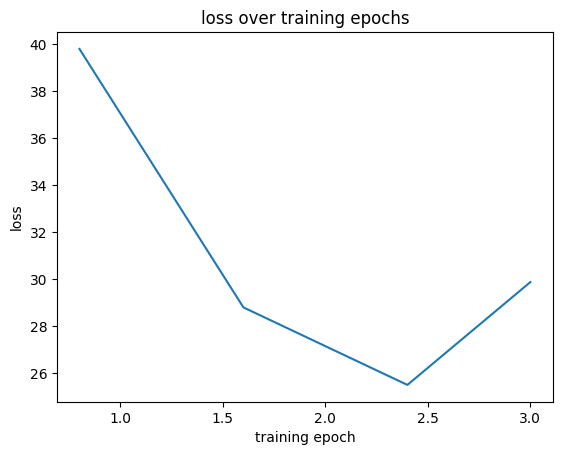

In [3]:
training_loss = [39.793, 28.807, 25.512, 29.883]
training_epochs = [0.8, 1.6, 2.4, 3]
plt.plot(training_epochs, training_loss)
plt.xlabel("training epoch")
plt.ylabel("loss")
plt.title("loss over training epochs")
plt.savefig("loss_output_plot.png")